In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [23]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout 

In [24]:
pd.set_option('display.max_colwidth', None)
root_folder = '/kaggle/input/nlp-getting-started/'

In [25]:
df_train = pd.read_csv(root_folder+'train.csv', sep=',', encoding='ISO-8859-1')
df_test = pd.read_csv(root_folder+'test.csv', sep=',', encoding='ISO-8859-1')
df_train.head(10)
print("Number of empty entries: ",np.sum(df_train.isnull().any(axis=1)))

Number of empty entries:  2533


In [26]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

STOPWORDS = set(stopwordlist)

In [27]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_urls(text):
    new_text = re.sub(r'http?:\/\/.*[\r\n]*', "", text)
    new_text = re.sub(r'https?:\/\/.*[\r\n]*', "", new_text)
    #new_text = re.sub(r'@[a-zA-Z0-9]', "", new_text)
    new_text = ' '.join(x for x in new_text.split() if not x.startswith('@'))
    return new_text.casefold().strip()

def remove_specials(text):
    #new_text = re.sub(r"[^a-zA-Z0-9\s]",'',text)
    new_text = re.sub(r"[^a-zA\s]",'',text)
    new_text=new_text.replace("#","").strip()
    return new_text.strip()

In [28]:
df_train['text'] = df_train.text.apply(remove_urls).dropna()
df_test['text'] = df_test.text.apply(remove_urls)
df_train.sample(10)

,id,keyword,location,text,target
7324,10484,wild%20fires,United States of America,wild fires in california... must be global warming. can't just be extreme heat combined with dry foliage ignited by some douchebag hiker.,1
2291,3286,demolish,"London, UK",the far right racist #avigdorliberman calls for destruction of #susiya ! previously he also called for beheadings!,1
1132,1632,bombing,Shipwreck Cove,it's been 70 years (and one hour) since the bombing of hiroshima. let's take this time to remember.,1
4399,6255,hijacking,EastCarolina,#hot funtenna: hijacking computers to send data as sound waves [black hat 2015],0
3643,5192,fatalities,PekanbaruÃ¥Â¡Batam IslandÃ¥Â¡Medan,there have been zero spider bite-related fatalities in australia since 1979.,0
447,649,attack,NYC,credit to for inspiring me to rediscover this fantabulous #tbt,0
3209,4604,emergency%20services,"Olympia, WA",#nursing alert: emergency department psychiatric rn (.90 fte day) | providence health &amp; services | #olympia wa,1
4561,6484,injured,India,udhampur terror attack: militants attack police post 2 spos injured: suspected militants tonight attacked a p...,1
6464,9248,sunk,glasgow,near them on the sand half sunk a shattered visage lies...,1
2334,3359,demolition,MA,demolition 1 &amp; 2 still the most fire freestyles ever,0


In [29]:
df_train['text'] = df_train.text.apply(remove_specials)
df_test['text'] = df_test.text.apply(remove_specials)
df_train.sample(10)

,id,keyword,location,text,target
3798,5392,fire%20truck,"Tallahassee, FL",toddler bedding firetruck bundle fire truck firefighter sticker decals sign wall,0
5457,7784,police,NaN,police man killed ex grandmother after son wasnampt named after him,1
4607,6550,injury,NaN,poster ergo rotator cuff injury recovery kit,0
2186,3133,debris,India,mh aircraft debris found on la reunion is from missing malaysia airlines abc online,1
4874,6939,mass%20murderer,"Tama, Iowa",nazi mass murderer became chairman at vaccine drug company in,1
261,372,annihilation,NaN,we need helphorses will die please rt amp sign petition take a stand amp be a voice for them gilbert,0
5468,7802,quarantine,NaN,reddit updates content policy promises to quarantine extremely offensive communities,0
4882,6951,massacre,"Ashburn, VA",i just bought tickets to death bed dude bro party massacre iii w live at,0
5133,7320,nuclear%20reactor,NaN,i would cry in to my nuclear reactor cooling tank winechat,0
4589,6527,injuries,"Georgia, U.S.A.",what a fucking idiot he had a gun amp a hatchet yet there were still no serious injuries glad police terminated him,1


In [30]:
df_train['text'] = df_train.text.apply(lambda x: cleaning_stopwords(x))
df_test['text'] = df_test.text.apply(lambda x: cleaning_stopwords(x))
df_train = df_train.drop(['keyword','location'], axis=1)
df_test = df_test.drop(['keyword','location'], axis=1)
df_train.sample(10)

,id,text,target
1878,2698,nowplaying fitz tantrums league crush listen,0
2573,3690,politics preschool attitude russia orders destroy food coming countries doesnt like no hunger world,1
5928,8463,brooke face timed concert screamed minutes straight,0
7004,10041,like gg bad end but least cared little gg dan cause twister dont know wilden idc,0
907,1312,eh hello cover bloody thighs bloody cleav eh hello since expose cleavage,0
4046,5746,forest service spends gt budget fighting fires,1
2846,4092,angry woman openly accuses nema stealing relief materials meant idps angry internally displaced wom,0
7108,10184,desert storm unqualified victory treaty signed clinton situation got worse violent tcot,1
2022,2902,said superficial wounds pepper spray damage,1
3015,4329,currently driving dust storm,1


Set train and validation data

In [31]:
x = df_train.sort_values(by= ['id'], ascending=True)
x_test = df_test.sort_values(by= ['id'], ascending=True)
#Retrieve the text from the dataframe as a numpy array
twitts = x.loc[:,x.columns=='text'].values.flatten()
twitts_test = x_test.loc[:,x_test.columns=='text'].values.flatten()

NLP 


In [32]:
t = Tokenizer()
def preprocess(text):
    seqs = t.fit_on_texts(text)
    return seqs
#fit tokenizer on training set:
tokens=preprocess(twitts)
#text to sequences
X_train = t.texts_to_sequences(twitts)
X_test = t.texts_to_sequences(twitts_test)

In [33]:
X_train = np.array(X_train, dtype=object)
X_test = np.array(X_test, dtype=object)
X_train = keras.preprocessing.sequence.pad_sequences(X_train)
X_test = keras.preprocessing.sequence.pad_sequences(X_test)
print(X_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0 4011  684  216   55 1502 4012   15]


In [34]:
vocab_size = len(t.word_index)
print('Size of vocabulary:', vocab_size)

Size of vocabulary: 14161


In [35]:
y_train = df_train.target.values

In [36]:
# validation split
from sklearn.model_selection import train_test_split
x_train, x_val, y, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("Training data shape: ", x_train.shape)
print("Validation data shape: ", x_val.shape)

Training data shape:  (6090, 23)
Validation data shape:  (1523, 23)


In [37]:
#create the model (try experimenting with your own architectures )
#create the model
model = Sequential()
model.add(Embedding(input_dim = vocab_size+2, output_dim = 128, name='Embedding'))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LSTM(128))
model.add(Dense(128, activation = 'relu'))
#model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, None, 128)         1812864   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(x_train, y, validation_data=(x_val,y_val), shuffle=True, epochs=5, batch_size=64)

Epoch 1/5
96/96 [==============================] - 14s 105ms/step - loss: 0.6808 - accuracy: 0.5695 - val_loss: 0.6677 - val_accuracy: 0.5739
Epoch 2/5
96/96 [==============================] - 9s 91ms/step - loss: 0.6523 - accuracy: 0.5695 - val_loss: 0.6198 - val_accuracy: 0.5739
Epoch 3/5
96/96 [==============================] - 9s 91ms/step - loss: 0.5086 - accuracy: 0.7148 - val_loss: 0.5080 - val_accuracy: 0.7722
Epoch 4/5
96/96 [==============================] - 10s 102ms/step - loss: 0.3379 - accuracy: 0.8594 - val_loss: 0.5388 - val_accuracy: 0.7741
Epoch 5/5
96/96 [==============================] - 9s 91ms/step - loss: 0.2638 - accuracy: 0.8933 - val_loss: 0.6397 - val_accuracy: 0.7387


In [39]:
train_score = model.evaluate(x_val, y_val)

48/48 [==============================] - 1s 17ms/step - loss: 0.6397 - accuracy: 0.7387


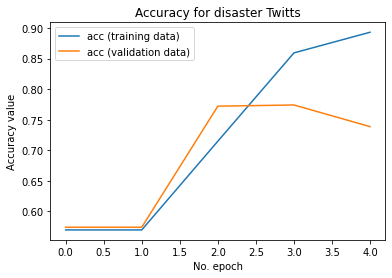

In [40]:
# Plot history: Accuracy
plt.plot(history.history['accuracy'], label='acc (training data)')
plt.plot(history.history['val_accuracy'], label='acc (validation data)')
plt.title('Accuracy for disaster Twitts')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [46]:
preds = np.where(model.predict(X_test)>0.5,1.0,0.0).flatten().astype('int32')
results = {'id':x_test['id'], 'target':preds}
df_results = pd.DataFrame(results)
df_results.sample(3263)
df_results.sort_values(by=['id'])
print(df_results[:3263])
df_results[:3263].to_csv('first_submission.csv', index=False)

         id  target
0         0       0
1         2       1
2         3       1
3         9       0
4        11       1
...     ...     ...
3258  10861       1
3259  10865       0
3260  10868       0
3261  10874       1
3262  10875       0

[3263 rows x 2 columns]
